In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Generel liberires
import os 
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


# deep lerning 
import tensorflow as tf
from tensorflow import keras
import keras.backend as k
from keras.models import Model,Sequential,save_model,load_model
from keras.layers import Input,Dense,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,SeparableConv2D,MaxPool2D,LeakyReLU,Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# New section

In [ ]:
input_path='/content/drive/MyDrive/dataset/chest_xray/'
def process_data(img_dims, batch_size):
  train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_set = train_datagen.flow_from_directory(
  directory= input_path + "train_set",
  target_size=(img_dims, img_dims),
  batch_size=batch_size,
  class_mode="binary",
  shuffle=True)
  
  val_set = test_datagen.flow_from_directory(
  directory= input_path + "val_set",
  target_size=(img_dims, img_dims),
  batch_size=batch_size,
  class_mode="binary",
  shuffle=True)
   
  test_set = train_datagen.flow_from_directory(
  directory= input_path + "test_set",
  target_size=(img_dims, img_dims),   
  batch_size=batch_size,
  class_mode="binary",
  shuffle=True)
      
  return train_set, val_set,test_set
  

In [ ]:
 img_dims = 256
 epochs = 10
 batch_size = 32


train_set, val_set, test_set = process_data(img_dims, batch_size)



Found 5234 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_dims, img_dims, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=512,activation='relu'))


model.add(Dense(units=256,activation='relu'))


model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 128)       5

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=1, verbose=2,mode="max")

In [ ]:
history = model.fit_generator(train_set,
                              steps_per_epoch = train_set.samples//batch_size,
                              epochs=epochs,
                              validation_data = test_set,
                              validation_steps = test_set.samples//batch_size,callbacks=[lr_reduce])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 2330s 14s/step - loss: 0.6654 - accuracy: 0.8302 - val_loss: 3.0925 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 130s 796ms/step - loss: 0.2222 - accuracy: 0.9148 - val_loss: 2.1135 - val_accuracy: 0.6299

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 3/10
163/163 [==============================] - 130s 796ms/step - loss: 0.1608 - accuracy: 0.9429 - val_loss: 2.1093 - val_accuracy: 0.6266

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 4/10
163/163 [==============================] - 130s 798ms/step - loss: 0.1340 - accuracy: 0.9469 - val_loss: 0.3267 - val_accuracy: 0.8388

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 5/10
163/163 [==============================] - 129s 790ms/step - loss: 0.1254 - accuracy: 0.9500 - val_loss: 0.5897 - val_accuracy: 0.8322

Epoch 00005: ReduceLROnPlat

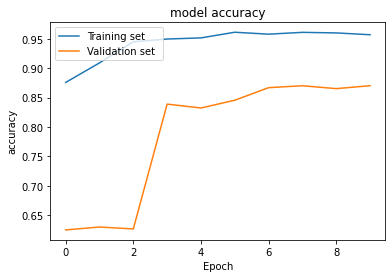

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Training set",  "Validation set "], loc="upper left" )
plt.show()

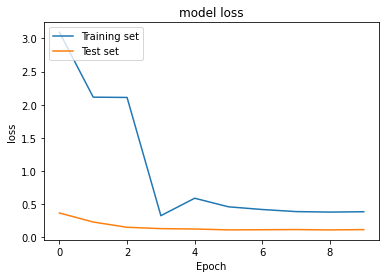

In [ ]:
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Training set",  "Test set "], loc="upper left" )
plt.show()

In [ ]:
test_set_data = []
test_labels = []
for cond in ["/NORMAL/", "/PNEUMONIA/"]:
  for img in (os.listdir(input_path + "test_set" + cond)):
      img = plt.imread(input_path+"test_set"+cond+img)
      img = cv2.resize(img,(img_dims,img_dims))
      img = np.dstack([img, img, img])
      img = img.astype("float32")/255
      if cond=="/NORMAL/":
         label = 0
      elif cond=="/PNEUMONIA/":
         label = 1
      test_set_data.append(img)
      test_labels.append(label)
test_set_data = np.array(test_set_data)
test_labels = np.array(test_labels)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
preds = model.predict(test_set_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()


print("CONFUSION MATRIX............")
print(cm)

print("/n TEST METRICS..................")

precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
sensitivity = tn/(tn+fp)
print("Accuracy : {}%".format(acc))
print("precision : {}%".format(precision))
print("REcall : {}%".format(recall))

print("F1 score : {}%".format(2*precision*recall/(precision+recall)))

print("\nTRAIN METRIC.................")
print("Train acc : {}". format(np.round((history.history["accuracy"][-1])*100, 2)))





CONFUSION MATRIX............
[[188  46]
 [ 11 379]]
/n TEST METRICS..................
Accuracy : 90.86538461538461%
precision : 89.17647058823529%
REcall : 97.17948717948718%
F1 score : 93.00613496932515%

TRAIN METRIC.................
Train acc : 95.67


In [ ]:
print(classification_report(test_labels, np.round(preds), target_names=["NORMAL", "phneumina"]))

              precision    recall  f1-score   support

      NORMAL       0.94      0.80      0.87       234
   phneumina       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



<Figure size 432x288 with 0 Axes>

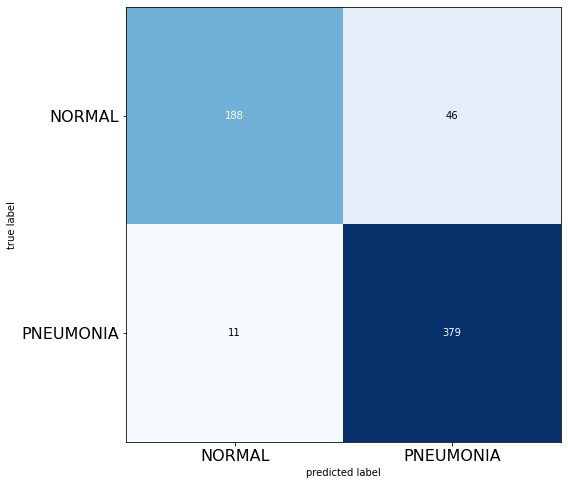

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ["NORMAL" , "PNEUMONIA"], fontsize=16)
plt.yticks(range(2), ["NORMAL" , "PNEUMONIA"], fontsize=16)
plt.show()




In [ ]:
from keras.models import save_model
filepath ="./91.5_model.h5"
save_model(model, filepath)

In [ ]:
from google.colab import files
files.download("/content/91.5_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>